<a href="https://colab.research.google.com/github/cataluna84/practical-dl-for-coders-part-2/blob/main/01_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

**Sujit:** The following notebook was consulted to adapt the material.

* https://github.com/fastai/course22p2/blob/master/nbs/01_matmul.ipynb


## What is Matrix Multiplication?

[Animation](https://www.geogebra.org/m/ETHXK756)

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from keras.datasets import mnist
from urllib.request import urlretrieve

import gzip
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import shutil
import time
import torch

## Import MNIST Dataset

Implementation uses URLRetrieve -- [read the docs](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve)

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
  urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Jun 10 14:38 mnist.pkl.gz


In [ ]:
with gzip.open(path_gz, 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
len(x_train), len(y_train), len(x_valid), len(y_valid)

(50000, 50000, 10000, 10000)

In [ ]:
type(x_train), type(y_train), type(x_valid), type(y_valid)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

In [ ]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

### Sidebar: discussion of iter

* [How to use Generators and yield in Python](https://realpython.com/introduction-to-python-generators/)

In [ ]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
      yield x[i:i+sz]

list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

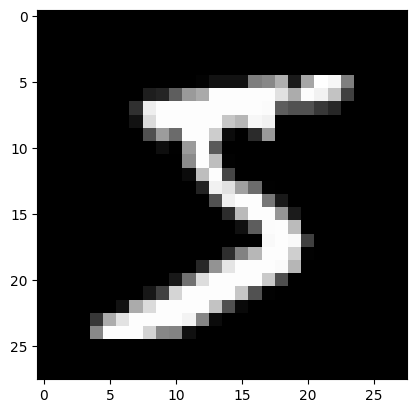

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

In [ ]:
from itertools import islice

it = iter(vals)
islice(it, 5)

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [ ]:
list(islice(it, 5))

[]

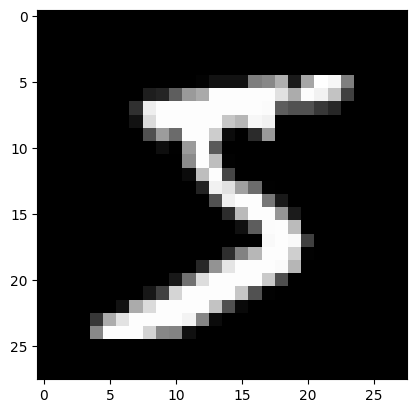

In [ ]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))
plt.imshow(img);

## Matrix and Tensor

In [ ]:
img[20][15]

0.98828125

In [ ]:
class Matrix:
    def __init__(self, xs):
      self.xs = xs

    def __getitem__(self, idxs):
      return self.xs[idxs[0]][idxs[1]]

m = Matrix(img)
m[20,15]

0.98828125

In [ ]:
from torch import tensor, from_numpy

torch.tensor([1, 2, 3])

tensor([1, 2, 3])

In [ ]:
# NOTE: to retain numpy dtype, need to pass in dtype or use torch.from_numpy
x_train, y_train, x_valid, y_valid = map(
    lambda x: tensor(x, dtype=torch.float32),
     (x_train, y_train, x_valid, y_valid))

<ipython-input-30-8699214b4786>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda x: tensor(x, dtype=torch.float32),


In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [ ]:
type(x_train), type(y_train), type(x_valid), type(y_valid)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [ ]:
imgs = x_train.reshape(-1, 28, 28)
imgs[0, 20, 15]

tensor(0.9883)

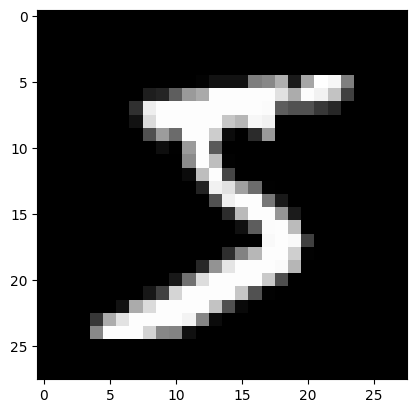

In [ ]:
plt.imshow(imgs[0])

In [ ]:
assert img[20][15] == imgs[0, 20, 15]
assert m[20, 15] == img[20][15]
assert m[20, 15] == imgs[0, 20, 15]

In [ ]:
n, c = x_train.shape

assert n == 50000
assert c == 784
assert y_train.min() == 0
assert y_train.max() == 9

## Random Numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

rand(), rand(), rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [ ]:
# not truly random
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In child: 0.9559050644103264In parent: 0.9559050644103264



In [ ]:
# how about numpy? Not truly random either
if os.fork(): print(f'In parent: {np.random.random(1)}')
else:
    print(f'In child: {np.random.random(1)}')
    os._exit(os.EX_OK)

In parent: [0.04305764]
In child: [0.04305764]


In [ ]:
# how about torch? Not truly random either
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In child: tensor([0.2638])
In parent: tensor([0.2638])


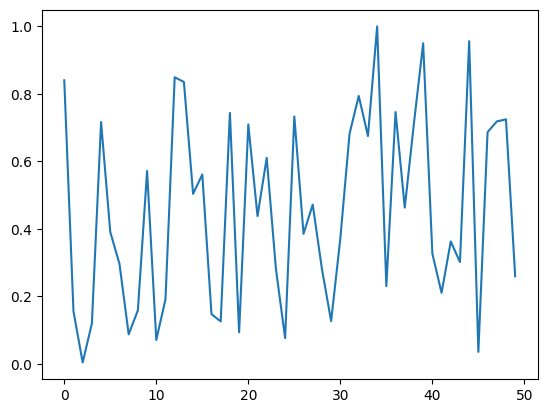

In [ ]:
plt.plot([rand() for _ in range(50)]);

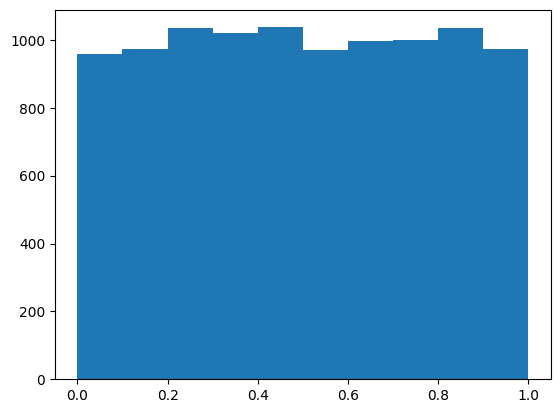

In [ ]:
plt.hist([rand() for _ in range(10000)]);

In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

3.91 ms ± 88 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 torch.randn(784,10)

56.5 µs ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix Multiplication

We posit a linear model of the following form.

```
y = wx + b

  y is of shape (n, c)    // c = number of classes
  x is of shape (n, 784)  // 28x28
  w is of shape (784, c). // project 784 to c
  b is of shape (1, c).   // bias term
```

In [ ]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

#### Naive version, Python only

__NOTE__: We consider a slice of 5 rows only, so the entire matrix would take approximately `50,000 / 5 = 10,000` times the time this takes.

In [ ]:
m1 = x_valid[:5]
m2 = weights

m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
ar, ac = m1.shape # n_rows * n_cols
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [ ]:
def matmul(a, b):
  (ar, ac), (br, bc) = a.shape, b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac):
        c[i,j] += a[i,k] * b[k,j]
  return c

%time t1 = matmul(m1, m2)

CPU times: user 806 ms, sys: 4.78 ms, total: 811 ms
Wall time: 810 ms


In [ ]:
results = []
result = %timeit -o -n 5 matmul(m1, m2)
results.append(("python", result.average, result.stdev))

801 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


#### Numba JIT

In [ ]:
from numba import njit

@njit
def dot(a, b):
  res = 0.
  for i in range(len(a)):
    res += a[i] * b[i]
  return res

In [ ]:
# NOTE: first time is slow since it JIT compiles
%time dot(np.array([1., 2, 3]), np.array([2., 3, 4]))

CPU times: user 430 ms, sys: 30.2 ms, total: 460 ms
Wall time: 457 ms


20.0

In [ ]:
%time dot(np.array([1., 2, 3]), np.array([2., 3, 4]))

CPU times: user 27 µs, sys: 4 µs, total: 31 µs
Wall time: 34.3 µs


20.0

In [ ]:
def matmul(a,b):
  (ar, ac), (br, bc) = a.shape, b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      # replace the inner loop with call to dot
      c[i, j] = dot(a[i, :], b[:, j])
  return c

m1a, m2a = m1.numpy(), m2.numpy()
%time t2 = matmul(m1a, m2a)

CPU times: user 503 µs, sys: 78 µs, total: 581 µs
Wall time: 587 µs


In [ ]:
result = %timeit -o -n 50 matmul(m1a, m2a)
results.append(("numba", result.average, result.stdev))

447 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Element-wise ops

We can also multiply a pair of tensors element-wise without having to invoke a function such as `dot`.

[TryAPL](https://tryapl.org/)

**With tensors of rank 1 (1-D tensors)**

In [ ]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [ ]:
a + b

tensor([12., 14.,  3.])

In [ ]:
(a < b).float().mean()

tensor(0.6667)

In [ ]:
a * b

tensor([ 20.,  48., -28.])

**With tensors of rank 2 (2-D tensors)**

In [ ]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

**Frobenius norm:**

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

*Hint-2*: [Online LaTex code editor](https://latex.codecogs.com/eqneditor/editor.php)

In [ ]:
sf = (m * m).sum().sqrt()
sf

tensor(16.8819)

In [ ]:
m[2, :], m[:, 2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [ ]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape,b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j] = (a[i,:] * b[:,j]).sum()
  return c

%time t3 = matmul(m1, m2)

CPU times: user 1.35 ms, sys: 56 µs, total: 1.41 ms
Wall time: 1.42 ms


In [ ]:
def test_close(a, b):
  return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

assert test_close(t1, t3)

In [ ]:
result = %timeit -o -n 50 matmul(m1, m2)
results.append(("element-wise", result.average, result.stdev))

1.21 ms ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Element-wise using torch.dot


In [ ]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape,b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j] = torch.dot(a[i,:], b[:,j])
  return c

%time t4 = matmul(m1, m2)

CPU times: user 1.14 ms, sys: 23 µs, total: 1.17 ms
Wall time: 1.17 ms


In [ ]:
assert test_close(t1, t4)

In [ ]:
reslt = %timeit -o -n 50 matmul(m1, m2)
results.append(("torch-dot", result.average, result.stdev))

901 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term broadcasting describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

```
The term broadcasting describes how numpy treats arrays with
different shapes during arithmetic operations. Subject to certain
constraints, the smaller array is “broadcast” across the larger
array so that they have compatible shapes. Broadcasting provides a
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of
data and usually leads to efficient algorithm implementations.
```
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

This section was adapted from [Chapter 4](https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra course](https://github.com/fastai/numerical-linear-algebra).

**Broadcasting with a scalar**

In [ ]:
a

tensor([10.,  6., -4.])

In [ ]:
a > 0

tensor([ True,  True, False])

How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [ ]:
a + 1

tensor([11.,  7., -3.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

**Broadcasting vector to matrix**

Although broadcasting a scalar (rank 0) is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector (rank 1) to a matrix (rank 2):



In [ ]:
c = tensor([10.,20,30])
c

tensor([10., 20., 30.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
assert test_close(m + c, c + m)

In [ ]:
# what is (logically) happening
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [ ]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
# We don't really copy the rows, but it looks as if we did.
# In fact, the rows are given a stride of 0.
t.storage()


<ipython-input-89-743f9a1d4daa>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()


 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [ ]:
# add an index along the row
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [ ]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [ ]:
# add an index along the column
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [ ]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means 'all preceding dimensions'

In [ ]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [ ]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [ ]:
c[:, None] + m

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [ ]:
c[None, :] + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

* they are equal, or
* one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256*256*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

```
Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3
```

The numpy documentation includes [several examples](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
# we want to multiply a row of m1 with m2
row = m1[0]
row.shape

torch.Size([784])

In [ ]:
lhs = row[:, None]
lhs.shape

torch.Size([784, 1])

In [ ]:
rhs = m2
prod = lhs * rhs

lhs.shape, rhs.shape, prod.shape

(torch.Size([784, 1]), torch.Size([784, 10]), torch.Size([784, 10]))

In [ ]:
lhs.expand_as(rhs).shape

torch.Size([784, 10])

In [ ]:
def matmul(a,b):
  (ar, ac), (br, bc) = a.shape,b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    c[i]   = (a[i, :, None] * b).sum(dim=0)
  return c

%time t5 = matmul(m1, m2)

CPU times: user 416 µs, sys: 0 ns, total: 416 µs
Wall time: 424 µs


In [ ]:
assert test_close(t1, t5)

In [ ]:
result = %timeit -o -n 50 matmul(m1, m2)
results.append(("broadcasting", result.average, result.stdev))

179 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Einstein Summation

[Einstein summation (einsum)](https://ajcr.net/Basic-guide-to-einsum/) is a compact representation for combining products and sums in a general way. The key rules are:

* Repeating letters between input arrays means that values along those axes will be multiplied together.
* Omitting a letter from the output means that values along that axis will be summed.

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
# to illustrate that you don't necessarily have to do sum
temp = torch.einsum('ik,kj->ikj', m1, m2)
temp.shape

torch.Size([5, 784, 10])

In [ ]:
temp.sum(dim=1).shape

torch.Size([5, 10])

In [ ]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
# mr = torch.einsum('ik,kj->ij', m1, m2)
t6 = torch.einsum('ik,kj->ij', m1, m2)

t6.shape

torch.Size([5, 10])

In [ ]:
def matmul(a, b):
  return torch.einsum('ik,kj->ij', a, b)

%time t6 = matmul(m1, m2)

CPU times: user 171 µs, sys: 28 µs, total: 199 µs
Wall time: 204 µs


In [ ]:
assert test_close(t1, t6)

In [ ]:
result = %timeit -o -n 5 matmul(m1, m2)
results.append(("einsum", result.average, result.stdev))

37 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Compare times

In [ ]:
results

[('python', 0.8011125614856999, 0.0040568841527844944),
 ('numba', 0.00044660110000352556, 1.1714148357105923e-05),
 ('element-wise', 0.0012094736714295452, 1.7133792763020913e-05),
 ('torch-dot', 0.0012094736714295452, 1.7133792763020913e-05),
 ('broadcasting', 0.00017887527143102487, 3.21747133758285e-06),
 ('einsum', 3.696291423693765e-05, 1.3004186815461947e-05)]

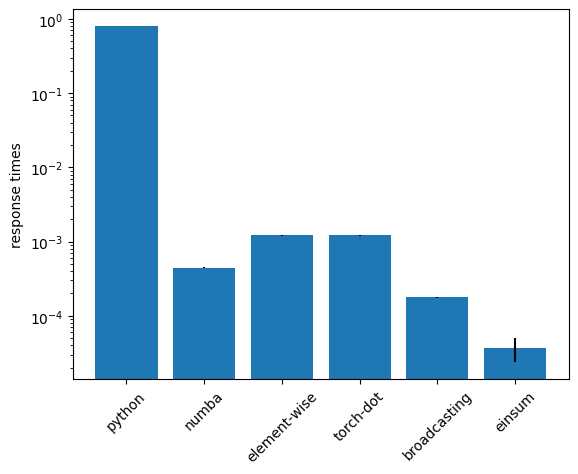

In [ ]:
xs = np.arange(len(results))
ys = [avg for _, avg, _ in results]
errs = [sd for _, _, sd in results]
plt.bar(xs, ys, yerr=errs)
plt.yscale("log")
plt.xticks(xs, [tag for tag, _, _ in results], rotation=45)
plt.ylabel("response times")
plt.show()

## Full Matrix Multiplication

In [ ]:
# now we can multiply the full matrix
tr = matmul(x_train, weights)
tr.shape

torch.Size([50000, 10])

In [ ]:
torch.set_printoptions(precision=2)

In [ ]:
%time matmul(x_train, weights)

CPU times: user 43.1 ms, sys: 0 ns, total: 43.1 ms
Wall time: 7.4 ms


tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [ ]:
full_results = []
result = %timeit -o -n 5 matmul(x_train, weights)
full_results.append(("einsum", result.average, result.stdev))

4.99 ms ± 898 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Pytorch's @ op and matmul

We can use pytorch's function or operator directly for matrix multiplication.

In [ ]:
tr2 = x_train @ weights
tr2.size()

torch.Size([50000, 10])

In [ ]:
assert test_close(tr, tr2)

In [ ]:
result = %timeit -o -n 5 x_train @ weights
full_results.append(("torch @", result.average, result.stdev))

4.74 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
tr3 = torch.matmul(x_train, weights)
tr3.size()

torch.Size([50000, 10])

In [ ]:
assert test_close(tr, tr3)

In [ ]:
result = %timeit -o -n 5 torch.matmul(x_train, weights)
full_results.append(("torch.matmul", result.average, result.stdev))

4.5 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [ ]:
# fake how this is done on GPU (many small tasks in parallel)
def matmul(grid, a, b, c):
  i, j = grid
  if i < c.shape[0] and j < c.shape[1]:
    tmp = 0.
    for k in range(a.shape[1]):
      tmp += a[i, k] * b[k, j]
    c[i,j] = tmp

res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,
           0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,
           0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,
           0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,
           0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,
           0.00]])

In [ ]:
# apply the matmul operation to all grid elements in matrix
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
  for i in range(grid_x):
    for j in range(grid_y):
      kernel((i,j), *args, **kwargs)

res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,
          -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,
          -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,
          13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,
           3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,
           5.28]])

In [ ]:
from numba import cuda

@cuda.jit
def matmul(a,b,c):
  i, j = cuda.grid(2)
  if i < c.shape[0] and j < c.shape[1]:
    tmp = 0.
    for k in range(a.shape[1]):
      tmp += a[i, k] * b[k, j]
    c[i,j] = tmp

In [ ]:
r = np.zeros(tr.shape)

r.shape

(50000, 10)

In [ ]:
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r))

In [ ]:
# for batching calls (boilerplate)
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [ ]:
matmul[blockspergrid, (TPB,TPB)](m1g, m2g, rg)
r = rg.copy_to_host()

In [ ]:
assert test_close(tr, tensor(r, dtype=torch.float))

In [ ]:
result = %timeit -o -n 10 matmul[blockspergrid, (TPB,TPB)](m1g, m2g, rg); r = rg.copy_to_host()
full_results.append(("cuda", result.average, result.stdev))

2.52 ms ± 48.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
m1c, m2c = x_train.cuda(), weights.cuda()
%time r = (m1c @ m2c).cpu()

CPU times: user 649 ms, sys: 371 ms, total: 1.02 s
Wall time: 1.02 s


In [ ]:
result = %timeit -o -n 10 (m1c @ m2c).cpu()
full_results.append(("torch @ (CUDA)", result.average, result.stdev))

871 µs ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Comparing results of full multiplication

In [ ]:
full_results

[('einsum', 0.0049897071428339195, 0.0008976027494807317),
 ('torch @', 0.004740149657144295, 0.0007569550232938922),
 ('torch.matmul', 0.004501231628559513, 0.00017313623661204759),
 ('cuda', 0.002521888371432267, 4.839799057512088e-05),
 ('torch @ (CUDA)', 0.0008714805285697886, 0.00026957308935307973)]

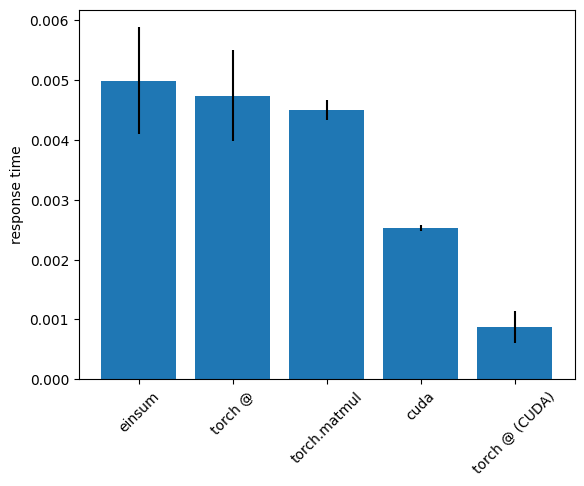

In [ ]:
labels = [label for label, _, _ in full_results]
times = [avg for _, avg, _ in full_results]
stdev = [stdev for _, _, stdev in full_results]
xs = np.arange(len(labels))
plt.bar(xs, times, yerr=stdev)
plt.xticks(xs, labels, rotation=45)
plt.ylabel("response time")
plt.show()